<a href="https://colab.research.google.com/github/ayuko66/akiya-lens/blob/main/notebook/akiya_lens_%E7%89%B9%E5%BE%B4%E9%87%8F%E3%83%87%E3%83%BC%E3%82%BF%E7%A2%BA%E8%AA%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

空き家データ 特徴分析

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!pip install japanize-matplotlib
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=6ea7e36b678d3893248cb33d5b51f59d233ff85bfb4628eceb63a1b2b216ca0f
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


目的変数：df["空き家率_2023"] - df["空き家率_2018"]

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_projects/akiya-lens/features_master__wide__v1.csv')
df.head(3)

,市区町村コード,市区町村名,都道府県名,2018_15〜64歳人口,2018_15歳未満人口,2018_65歳以上人口,2018_出生数,2018_出生率[‰],2018_年少人口率[%],2018_死亡数,...,2023_転入者数,2023_転出者数,2023_高齢化率[%],2023_年少人口率[%],2023_生産年齢人口率[%],2023_出生率[‰],2023_死亡率[‰],2023_転入率[‰],2023_転出率[‰],2023_転入超過率[‰]
0,2201,青森市,青森県,170236,32574,84764,1752.0,6.092345,11.327171,3664.0,...,6468.0,7657.0,31.965583,10.527483,57.506934,4.645600,15.358107,23.511536,27.833616,-4.322080
1,2202,弘前市,青森県,101677,18977,53396,1110.0,6.377478,10.903189,2317.0,...,4141.0,4801.0,32.762569,10.479911,56.757520,4.964390,16.473841,24.888061,28.854765,-3.966704
2,2203,八戸市,青森県,137564,27841,66956,1600.0,6.885837,11.981787,2801.0,...,5722.0,6886.0,31.398086,11.280289,57.321625,5.142458,14.984291,25.609352,30.818944,-5.209592


## 特徴量相関分析

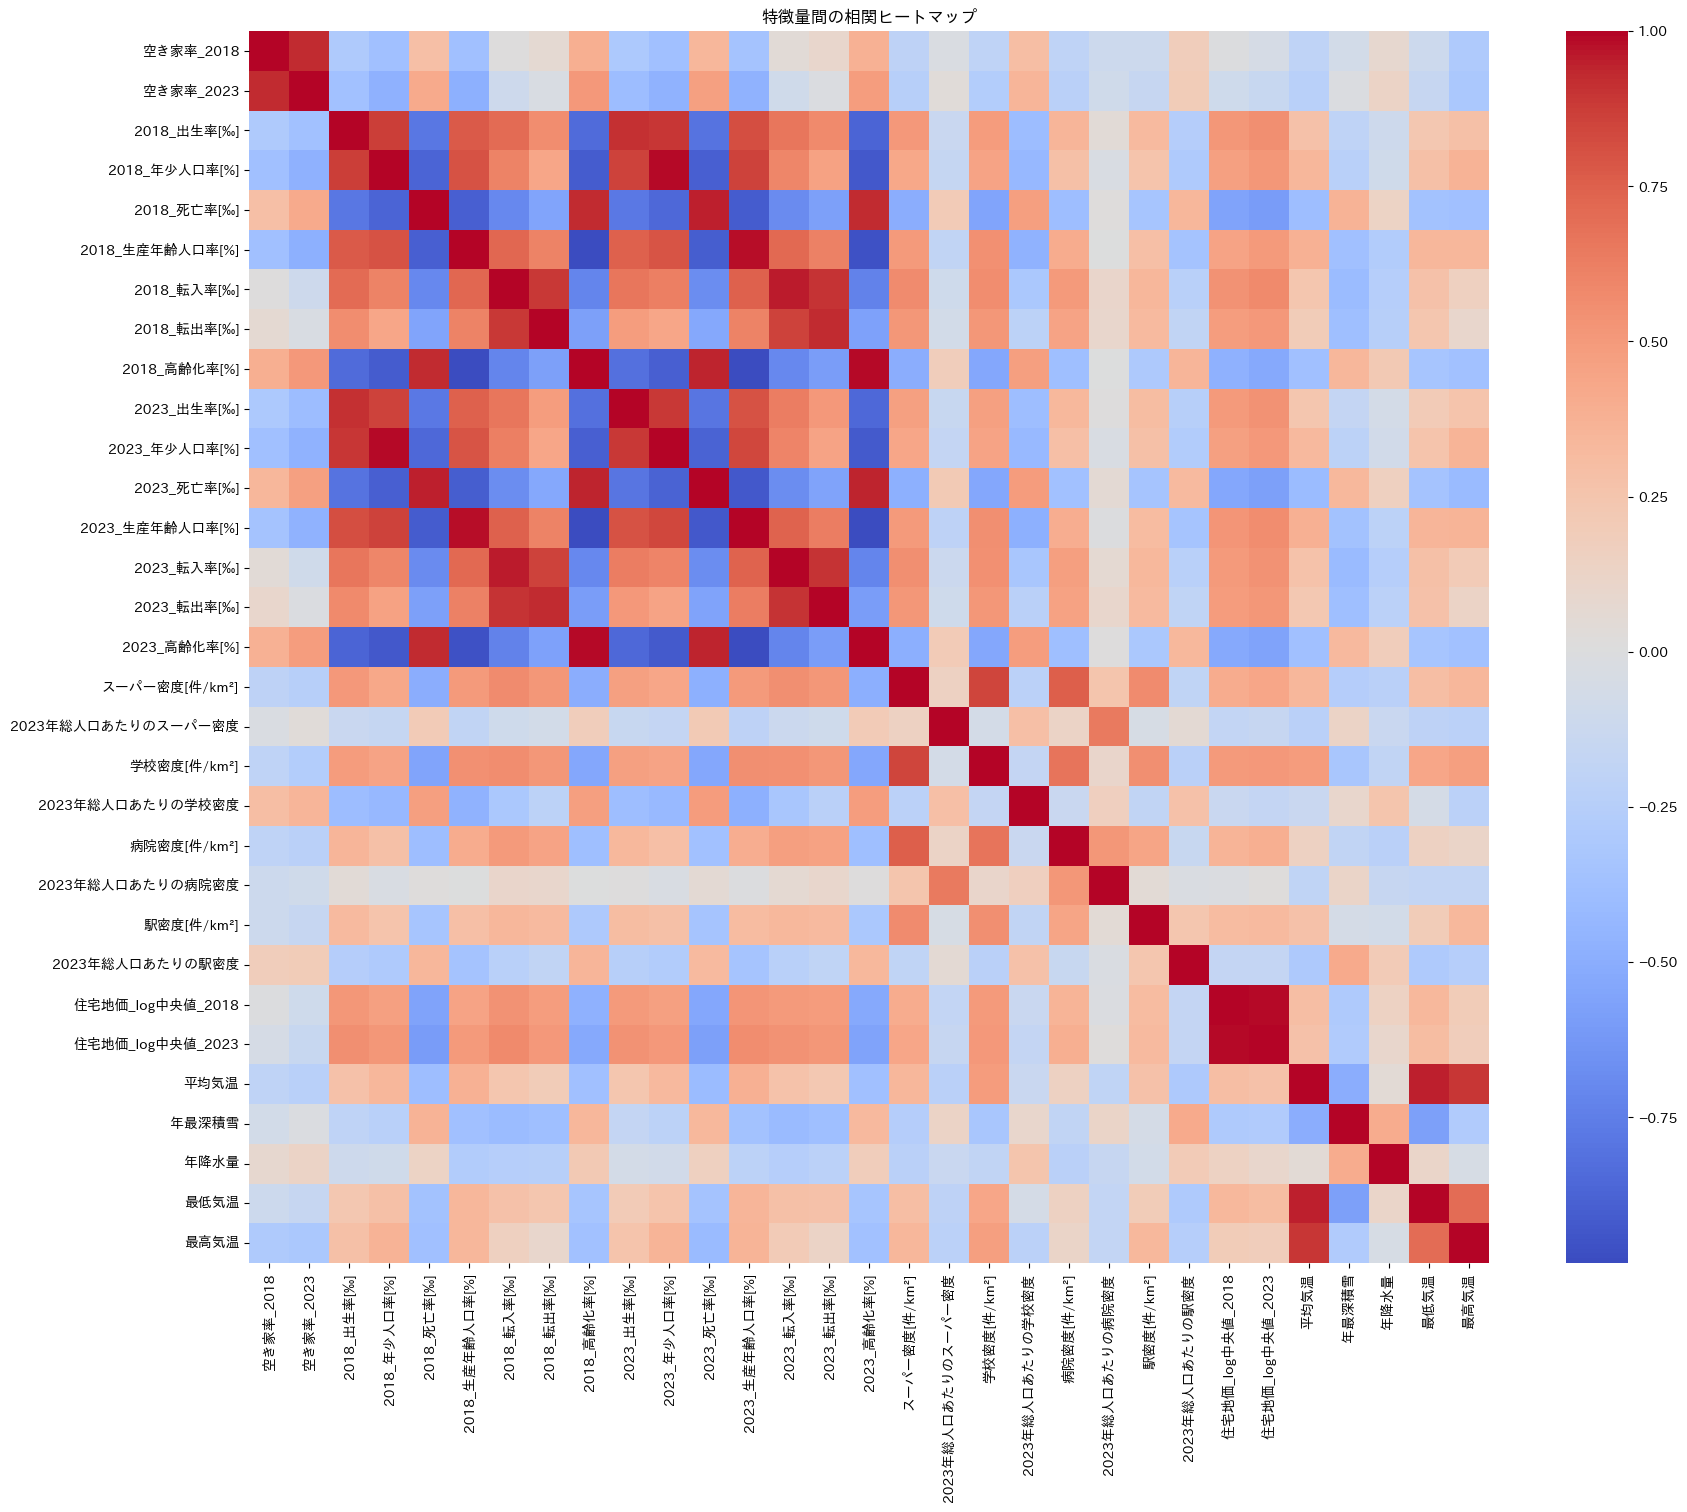

In [11]:
# 特徴量間の相関を確認
df_corr = df.copy()
df_corr.set_index('市区町村コード')
df_corr = df_corr[['空き家率_2018', '空き家率_2023',
                         '2018_出生率[‰]', '2018_年少人口率[%]',	'2018_死亡率[‰]', '2018_生産年齢人口率[%]', '2018_転入率[‰]', '2018_転出率[‰]', '2018_高齢化率[%]',
                         '2023_出生率[‰]', '2023_年少人口率[%]',	'2023_死亡率[‰]', '2023_生産年齢人口率[%]', '2023_転入率[‰]', '2023_転出率[‰]', '2023_高齢化率[%]',
                         'スーパー密度[件/km²]', '2023年総人口あたりのスーパー密度', '学校密度[件/km²]','2023年総人口あたりの学校密度', '病院密度[件/km²]', '2023年総人口あたりの病院密度',
                         '駅密度[件/km²]', '2023年総人口あたりの駅密度',
                         '住宅地価_log中央値_2018', '住宅地価_log中央値_2023', '平均気温', '年最深積雪', '年降水量', '最低気温', '最高気温', '過疎地域市町村']]

df_corr = pd.get_dummies(df_corr, columns=['過疎地域市町村'])

numeric_df = df_corr.select_dtypes(include=np.number)


# ピアソン相関係数
correlation_matrix_all = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix_all, annot=False, cmap='coolwarm')
plt.title('特徴量間の相関ヒートマップ')
plt.show()

## 多重共線性回避のためペアワイズ相関を可視化

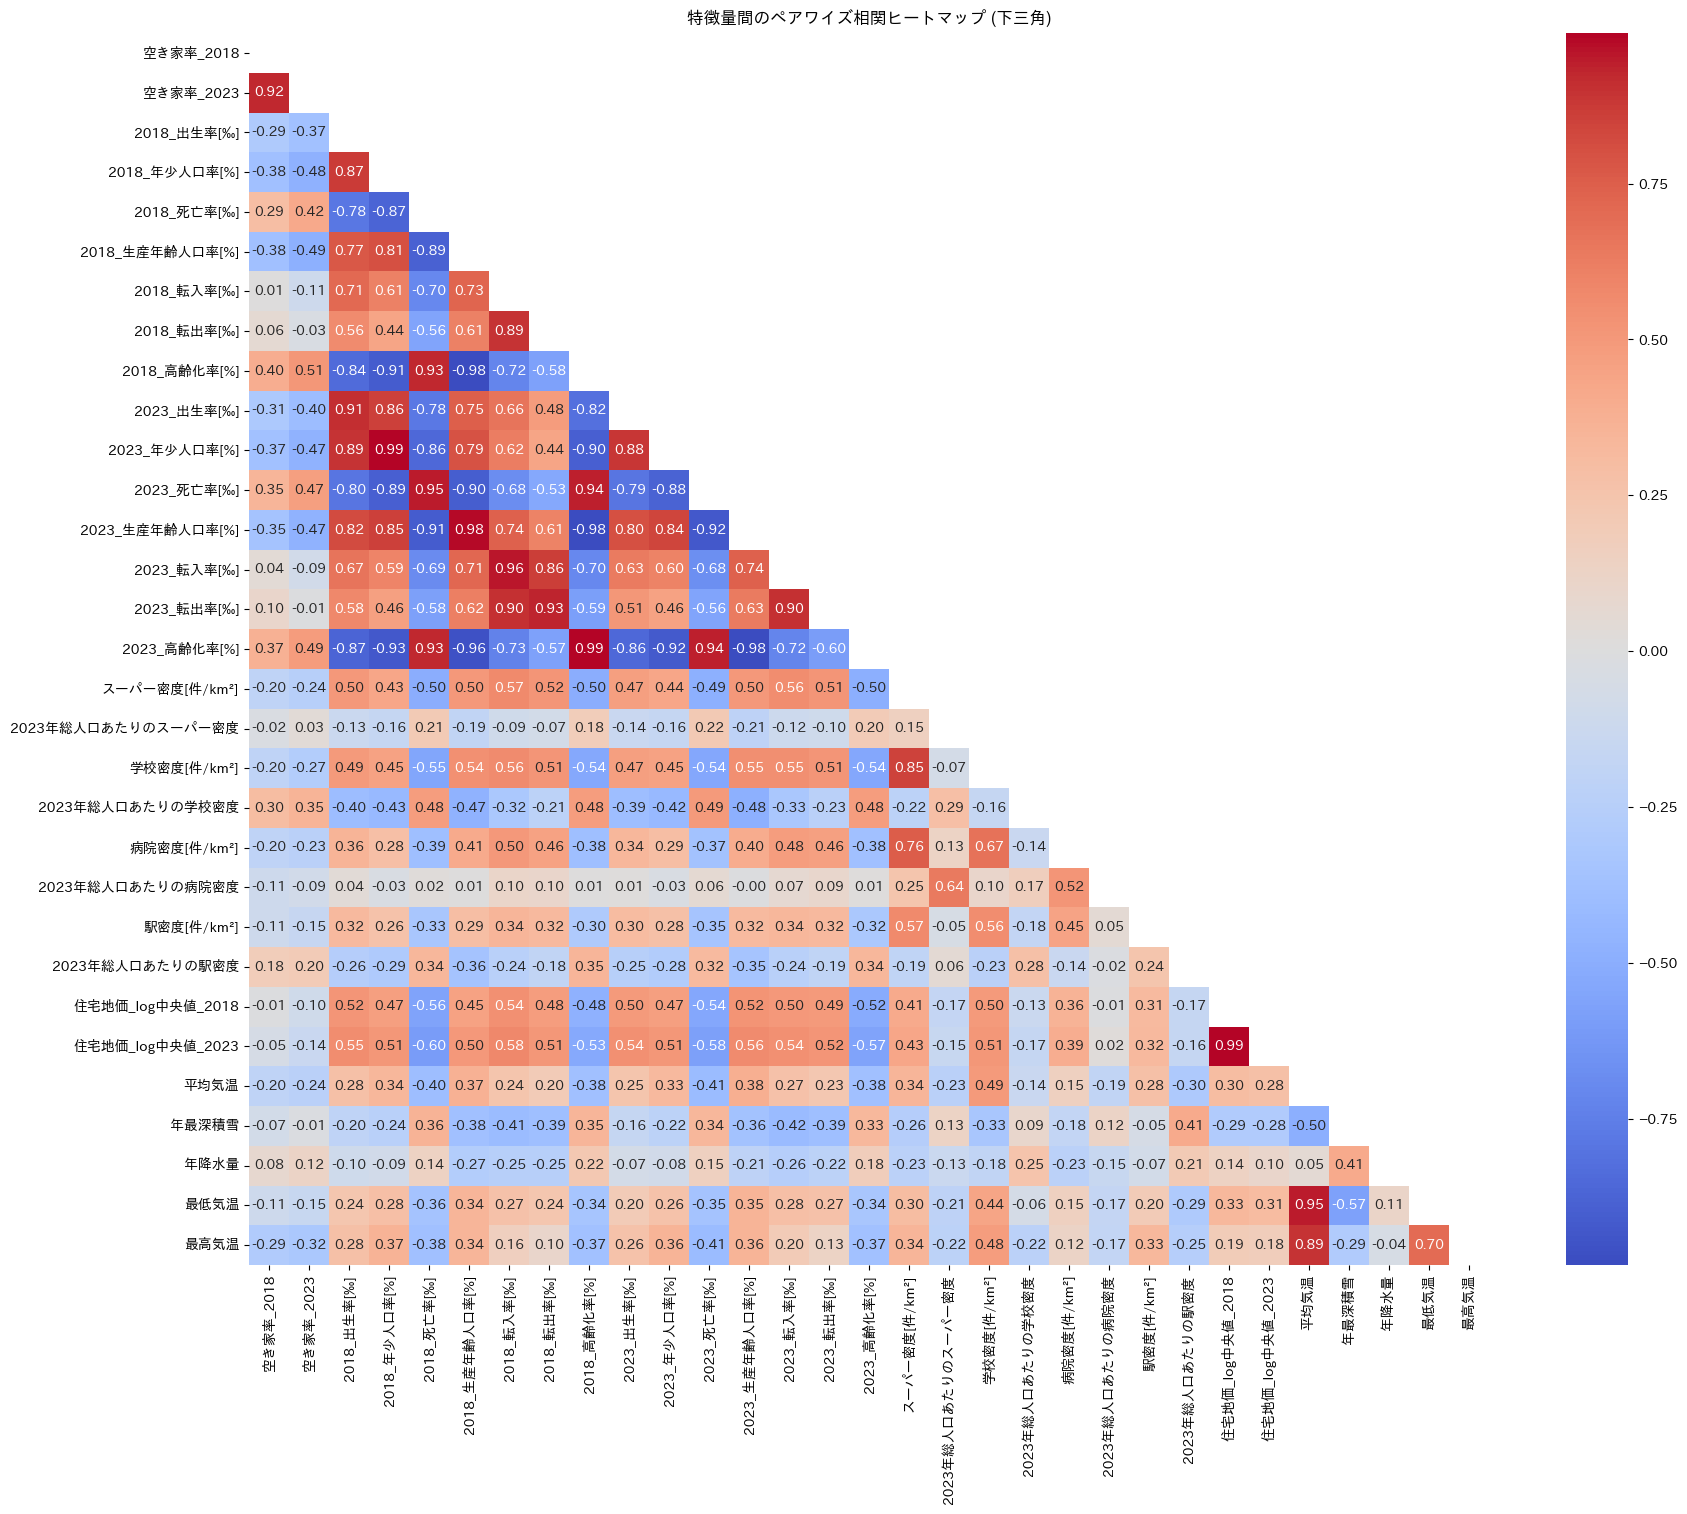

In [12]:
# ピアソン相関係数
correlation_matrix = numeric_df.corr()

# ヒートマップの上三角部分を隠すためのマスクを作成 (相関行列は対角線に対して対称のため)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with annotations
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('特徴量間のペアワイズ相関ヒートマップ (下三角)')
plt.show()

In [13]:
# 市区町村コードごとの空き家率関連の特徴量の分布と分散を確認
df['空き家率_変化量'] = df['空き家率_2023'] - df['空き家率_2018']
akiya_stats_by_city = df.groupby('市区町村コード')[['空き家率_2018', '空き家率_2023', '空き家率_変化量']].agg(['count', 'mean', 'std', 'min', 'max'])

print("市区町村コードごとの空き家率の分布と分散:\n", akiya_stats_by_city)

市区町村コードごとの空き家率の分布と分散:
         空き家率_2018                                空き家率_2023                    \
            count     mean std      min      max     count   mean std    min   
市区町村コード                                                                        
2201            1  14.5829 NaN  14.5829  14.5829         1  15.09 NaN  15.09   
2202            1  14.1178 NaN  14.1178  14.1178         1  15.78 NaN  15.78   
2203            1  15.3658 NaN  15.3658  15.3658         1  17.94 NaN  17.94   
2204            1  13.3432 NaN  13.3432  13.3432         1  12.57 NaN  12.57   
2205            1  17.3575 NaN  17.3575  17.3575         1  17.76 NaN  17.76   
...           ...      ...  ..      ...      ...       ...    ...  ..    ...   
25212           1  21.0158 NaN  21.0158  21.0158         1  23.05 NaN  23.05   
25213           1  13.6496 NaN  13.6496  13.6496         1  17.49 NaN  17.49   
25214           1  13.9333 NaN  13.9333  13.9333         1  14.63 NaN  14.63   
25383           1

In [14]:
!pip install japanize-matplotlib
import japanize_matplotlib

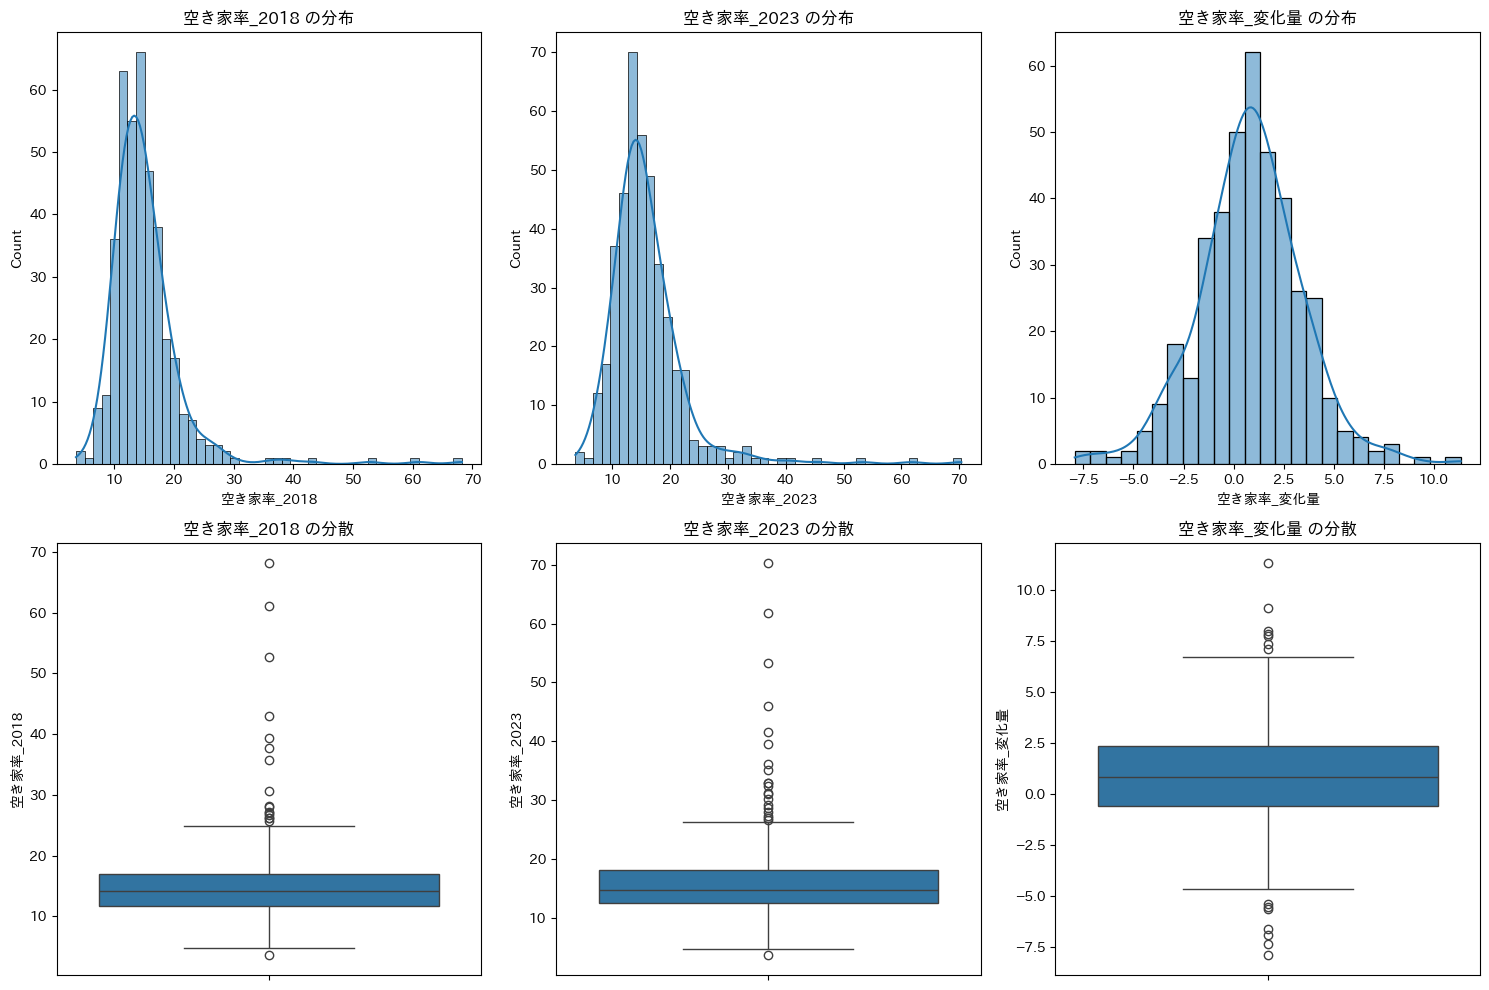

In [15]:
# 空き家率関連の特徴量の分布と分散を可視化
# 日本語表示をサポートするjapanize-matplotlibを使用

plt.figure(figsize=(15, 10))

# ヒストグラム
plt.subplot(2, 3, 1)
sns.histplot(df['空き家率_2018'], kde=True)
plt.title('空き家率_2018 の分布')

plt.subplot(2, 3, 2)
sns.histplot(df['空き家率_2023'], kde=True)
plt.title('空き家率_2023 の分布')

plt.subplot(2, 3, 3)
sns.histplot(df['空き家率_変化量'], kde=True)
plt.title('空き家率_変化量 の分布')

# 箱ひげ図
plt.subplot(2, 3, 4)
sns.boxplot(y=df['空き家率_2018'])
plt.title('空き家率_2018 の分散')

plt.subplot(2, 3, 5)
sns.boxplot(y=df['空き家率_2023'])
plt.title('空き家率_2023 の分散')

plt.subplot(2, 3, 6)
sns.boxplot(y=df['空き家率_変化量'])
plt.title('空き家率_変化量 の分散')


plt.tight_layout()
plt.show()

In [16]:
# 特徴量の選択
features_for_clustering = df[['空き家率_2018', '空き家率_2023', '空き家率_変化量']]

# データのスケーリング
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled_array = scaler.fit_transform(features_for_clustering)
features_scaled = pd.DataFrame(features_scaled_array, columns=features_for_clustering.columns)

# NaN値の処理と対応する行の削除
features_scaled_cleaned = features_scaled.dropna()
cleaned_indices = features_scaled_cleaned.index
df_cleaned = df.loc[cleaned_indices].copy()

空き家率_2023 の Shapiro-Wilk 検定: 統計量=0.750, p値=0.000
空き家率_2023 は正規分布に従わない可能性が高いです。
空き家率_変化量 の Shapiro-Wilk 検定: 統計量=0.987, p値=0.002
空き家率_変化量 は正規分布に従わない可能性が高いです。


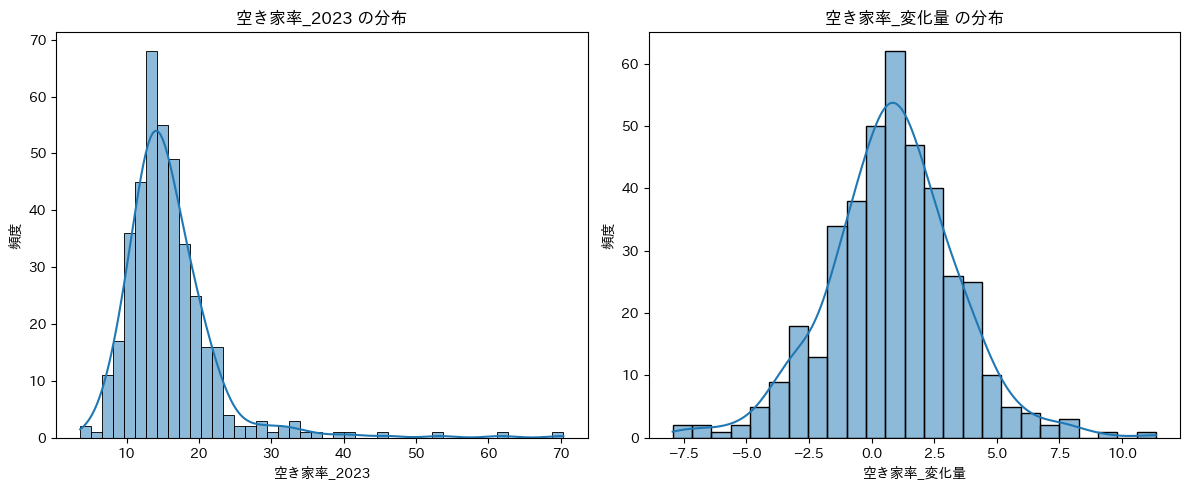

In [17]:
from scipy.stats import shapiro

# 空き家率_2023 の正規分布の確認
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned['空き家率_2023'], kde=True)
plt.title('空き家率_2023 の分布')
plt.xlabel('空き家率_2023')
plt.ylabel('頻度')

# Shapiro-Wilk 検定
stat, p = shapiro(df_cleaned['空き家率_2023'])
print(f'空き家率_2023 の Shapiro-Wilk 検定: 統計量={stat:.3f}, p値={p:.3f}')
if p > 0.05:
    print('空き家率_2023 は正規分布に従う可能性が高いです。')
else:
    print('空き家率_2023 は正規分布に従わない可能性が高いです。')


# 空き家率_変化量 の正規分布の確認
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['空き家率_変化量'], kde=True)
plt.title('空き家率_変化量 の分布')
plt.xlabel('空き家率_変化量')
plt.ylabel('頻度')

# Shapiro-Wilk 検定
stat, p = shapiro(df_cleaned['空き家率_変化量'])
print(f'空き家率_変化量 の Shapiro-Wilk 検定: 統計量={stat:.3f}, p値={p:.3f}')
if p > 0.05:
    print('空き家率_変化量 は正規分布に従う可能性が高いです。')
else:
    print('空き家率_変化量 は正規分布に従わない可能性が高いです。')

plt.tight_layout()
plt.show()

空き家率_2023 (対数変換後) の Shapiro-Wilk 検定: 統計量=0.963, p値=0.000
空き家率_2023 (対数変換後) は正規分布に従わない可能性が高いです。
空き家率_変化量 (オフセット+対数変換後) の Shapiro-Wilk 検定: 統計量=0.863, p値=0.000
空き家率_変化量 (オフセット+対数変換後) は正規分布に従わない可能性が高いです。


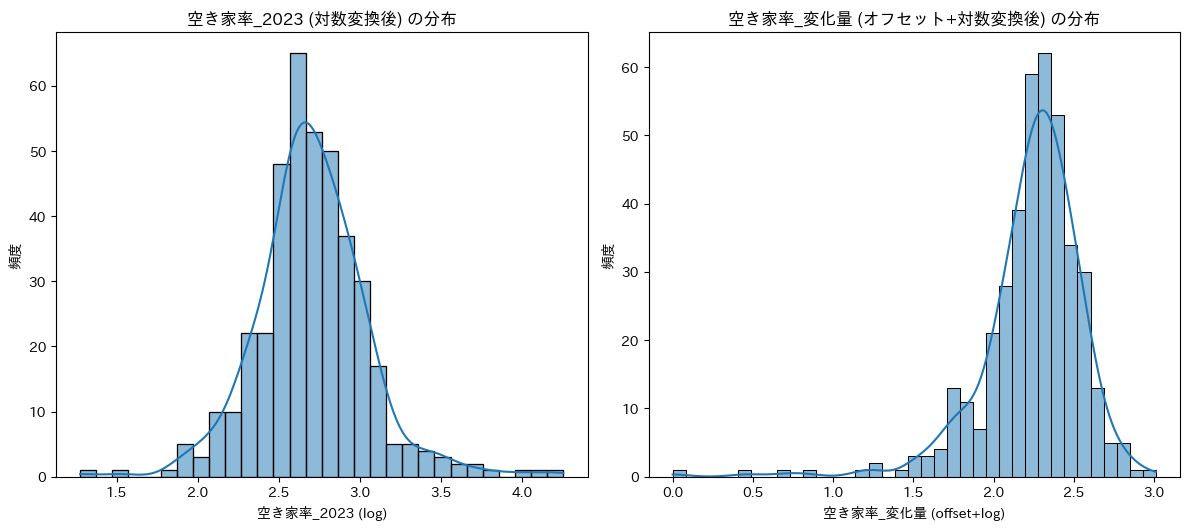

In [18]:
import numpy as np
from scipy.stats import shapiro

# 対数変換（0以下の値がある場合は処理を検討）
# 空き家率_2023 は最小値が3.58なので対数変換可能
df_cleaned['空き家率_2023_log'] = np.log(df_cleaned['空き家率_2023'])

# 空き家率_変化量 は負の値を含むため、対数変換の前にオフセットを加えるか、別の変換方法を検討
# 今回はシンプルに、最小値を考慮してオフセットを加える（最小値が-7.9327なので、例えば+8すれば全て正になる）
offset = abs(df_cleaned['空き家率_変化量'].min()) + 1
df_cleaned['空き家率_変化量_offset_log'] = np.log(df_cleaned['空き家率_変化量'] + offset)


# 対数変換後の正規分布の確認
plt.figure(figsize=(12, 10))

# 空き家率_2023_log の正規分布の確認
plt.subplot(2, 2, 1)
sns.histplot(df_cleaned['空き家率_2023_log'], kde=True)
plt.title('空き家率_2023 (対数変換後) の分布')
plt.xlabel('空き家率_2023 (log)')
plt.ylabel('頻度')

# Shapiro-Wilk 検定
stat_log_2023, p_log_2023 = shapiro(df_cleaned['空き家率_2023_log'])
print(f'空き家率_2023 (対数変換後) の Shapiro-Wilk 検定: 統計量={stat_log_2023:.3f}, p値={p_log_2023:.3f}')
if p_log_2023 > 0.05:
    print('空き家率_2023 (対数変換後) は正規分布に従う可能性が高いです。')
else:
    print('空き家率_2023 (対数変換後) は正規分布に従わない可能性が高いです。')


# 空き家率_変化量_offset_log の正規分布の確認
plt.subplot(2, 2, 2)
sns.histplot(df_cleaned['空き家率_変化量_offset_log'], kde=True)
plt.title('空き家率_変化量 (オフセット+対数変換後) の分布')
plt.xlabel('空き家率_変化量 (offset+log)')
plt.ylabel('頻度')

# Shapiro-Wilk 検定
stat_log_change, p_log_change = shapiro(df_cleaned['空き家率_変化量_offset_log'])
print(f'空き家率_変化量 (オフセット+対数変換後) の Shapiro-Wilk 検定: 統計量={stat_log_change:.3f}, p値={p_log_change:.3f}')
if p_log_change > 0.05:
    print('空き家率_変化量 (オフセット+対数変換後) は正規分布に従う可能性が高いです。')
else:
    print('空き家率_変化量 (オフセット+対数変換後) は正規分布に従わない可能性が高いです。')

plt.tight_layout()
plt.show()

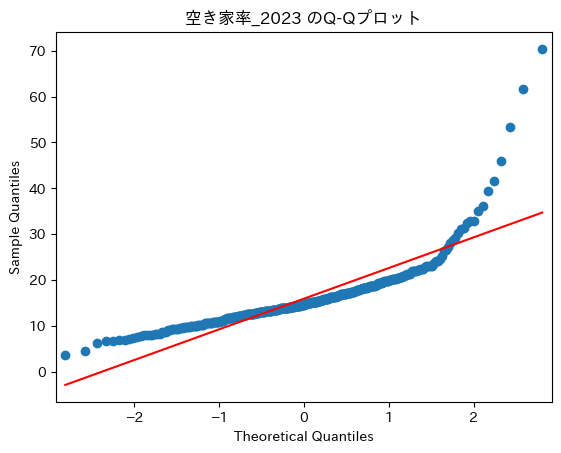

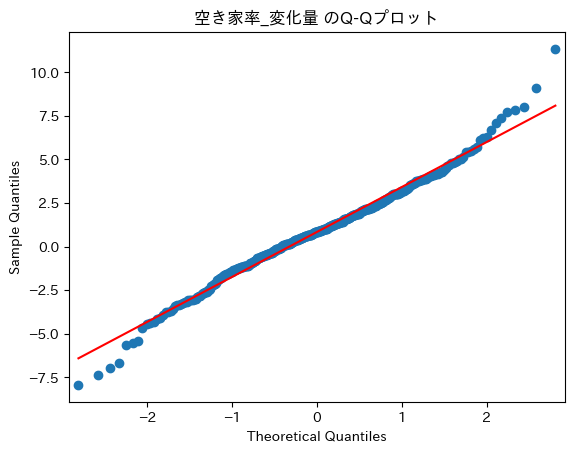

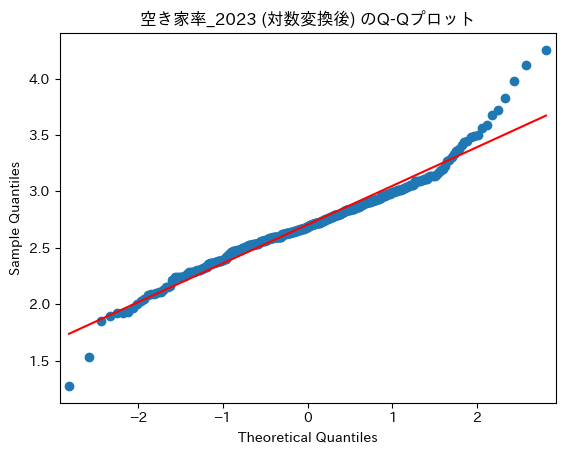

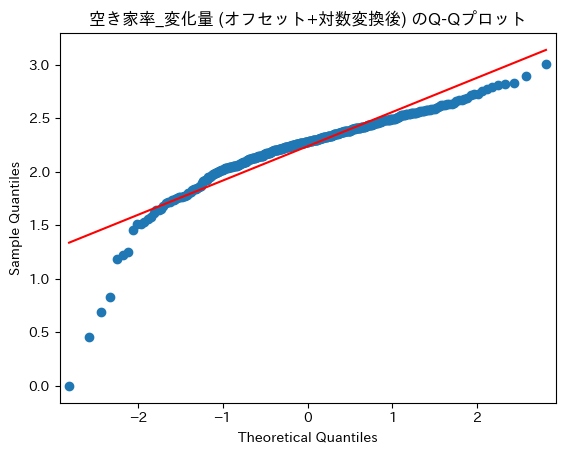

In [19]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Q-Qプロットで正規分布を確認

# 空き家率_2023 のQ-Qプロット
sm.qqplot(df_cleaned['空き家率_2023'], line='s')
plt.title('空き家率_2023 のQ-Qプロット')
plt.show()

# 空き家率_変化量 のQ-Qプロット
sm.qqplot(df_cleaned['空き家率_変化量'], line='s')
plt.title('空き家率_変化量 のQ-Qプロット')
plt.show()

# 空き家率_2023 (対数変換後) のQ-Qプロット
# df_cleaned['空き家率_2023_log']が既に存在することを確認
if '空き家率_2023_log' in df_cleaned.columns:
    sm.qqplot(df_cleaned['空き家率_2023_log'], line='s')
    plt.title('空き家率_2023 (対数変換後) のQ-Qプロット')
    plt.show()
else:
    print("「空き家率_2023_log」列が見つかりません。対数変換を実行してから再度お試しください。")


# 空き家率_変化量 (オフセット+対数変換後) のQ-Qプロット
# df_cleaned['空き家率_変化量_offset_log']が既に存在することを確認
if '空き家率_変化量_offset_log' in df_cleaned.columns:
    sm.qqplot(df_cleaned['空き家率_変化量_offset_log'], line='s')
    plt.title('空き家率_変化量 (オフセット+対数変換後) のQ-Qプロット')
    plt.show()
else:
    print("「空き家率_変化量_offset_log」列が見つかりません。対数変換を実行してから再度お試しください。")

## クラスタリング
目的変数の傾向から学習データをグルーピングをする

In [20]:
# クラスタリングの実行 (最適なクラスター数は前回のエルボー法の結果から4と仮定)
from sklearn.cluster import KMeans
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(features_scaled_cleaned)

# クラスターラベルをdf_cleanedに追加
df_cleaned['cluster_label'] = kmeans.labels_

# クラスタリング結果を含むDataFrameをCSVに出力
df_cleaned.to_csv('/content/clustered_akiya_data.csv', index=False)

print("クラスタリング結果を含むデータが /content/clustered_akiya_data.csv に出力されました。")

クラスタリング結果を含むデータが /content/clustered_akiya_data.csv に出力されました。


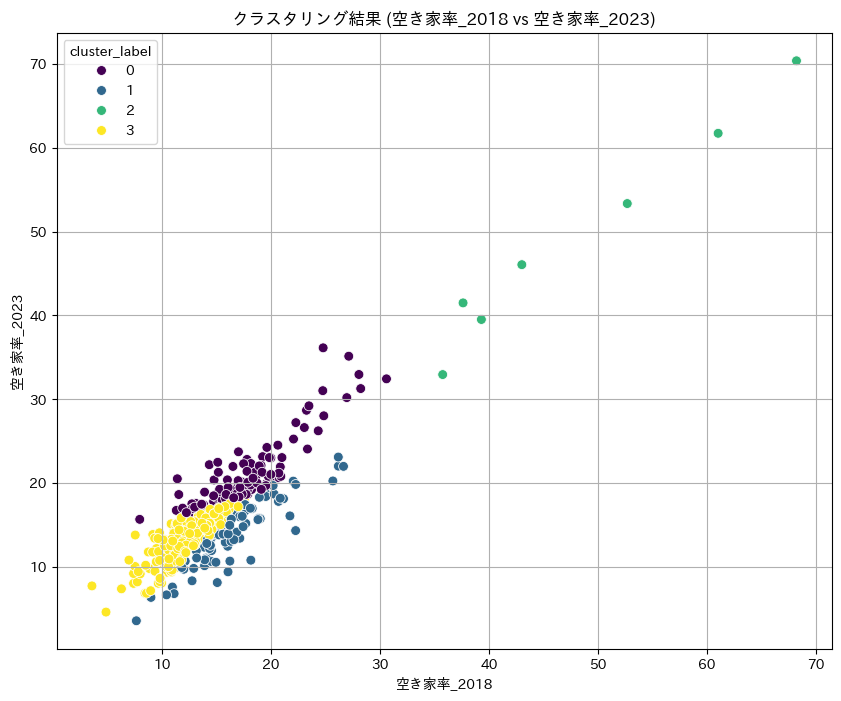

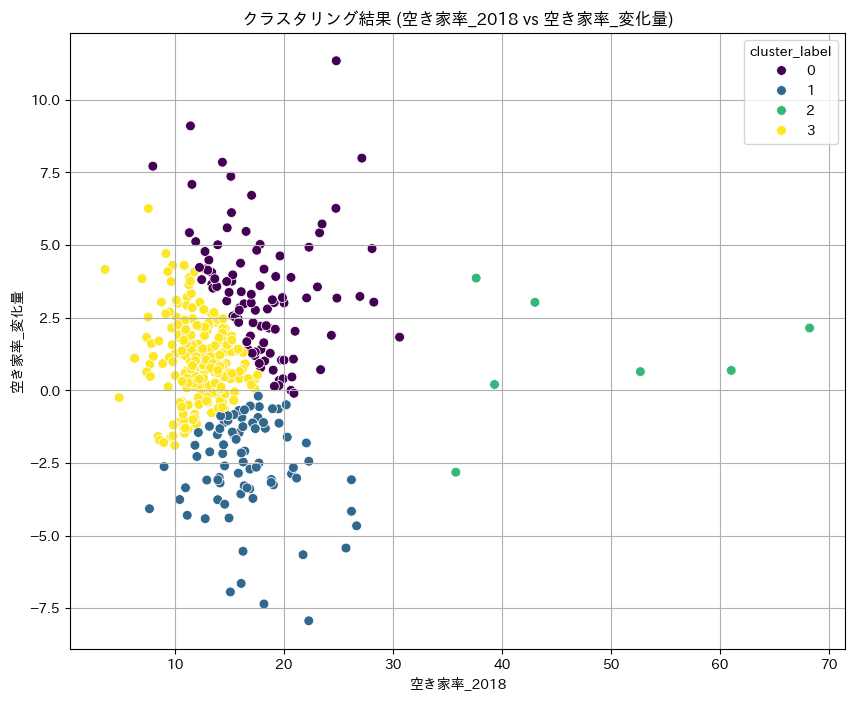


各クラスターの特徴量の平均値:
                空き家率_2018  空き家率_2023  空き家率_変化量
cluster_label                                
0              17.906762  21.258144  3.351382
1              16.655846  14.117927 -2.537920
2              48.248071  49.355714  1.107643
3              12.138771  13.129019  0.990248


In [21]:
import japanize_matplotlib
# クラスタリング結果の可視化 (空き家率_2018 vs 空き家率_2023)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_cleaned, x='空き家率_2018', y='空き家率_2023', hue='cluster_label', palette='viridis', s=50)
plt.title('クラスタリング結果 (空き家率_2018 vs 空き家率_2023)')
plt.xlabel('空き家率_2018')
plt.ylabel('空き家率_2023')
plt.grid(True)
plt.show()

# クラスタリング結果の可視化 (空き家率_2018 vs 空き家率_変化量)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_cleaned, x='空き家率_2018', y='空き家率_変化量', hue='cluster_label', palette='viridis', s=50)
plt.title('クラスタリング結果 (空き家率_2018 vs 空き家率_変化量)')
plt.xlabel('空き家率_2018')
plt.ylabel('空き家率_変化量')
plt.grid(True)
plt.show()


# 各クラスターの空き家率の平均値を計算
cluster_means = df_cleaned.groupby('cluster_label')[['空き家率_2018', '空き家率_2023', '空き家率_変化量']].mean()
print("\n各クラスターの特徴量の平均値:\n", cluster_means)

各クラスターの特徴量の要約統計量:
               空き家率_2018                                                    \
                  count       mean        std      min      25%       50%   
cluster_label                                                               
0                  97.0  17.906762   4.127652   7.9646  15.2139  17.49730   
1                  82.0  16.655846   3.648369   7.6555  14.4681  16.24830   
2                   7.0  48.248071  12.638575  35.7676  38.4775  43.02990   
3                 214.0  12.138771   2.342071   3.5800  10.6773  12.12745   

                                 空き家率_2023             ...                  \
                    75%      max     count       mean  ...      75%    max   
cluster_label                                          ...                   
0              19.85770  30.6088      97.0  21.258144  ...  22.3400  36.14   
1              18.25615  26.6640      82.0  14.117927  ...  16.3675  23.11   
2              56.87480  68.2344       7.0  49.3557

/tmp/ipython-input-1170699727.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_label', y=feature, data=df_cleaned, palette='viridis')
/tmp/ipython-input-1170699727.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_label', y=feature, data=df_cleaned, palette='viridis')
/tmp/ipython-input-1170699727.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_label', y=feature, data=df_cleaned, palette='viridis')


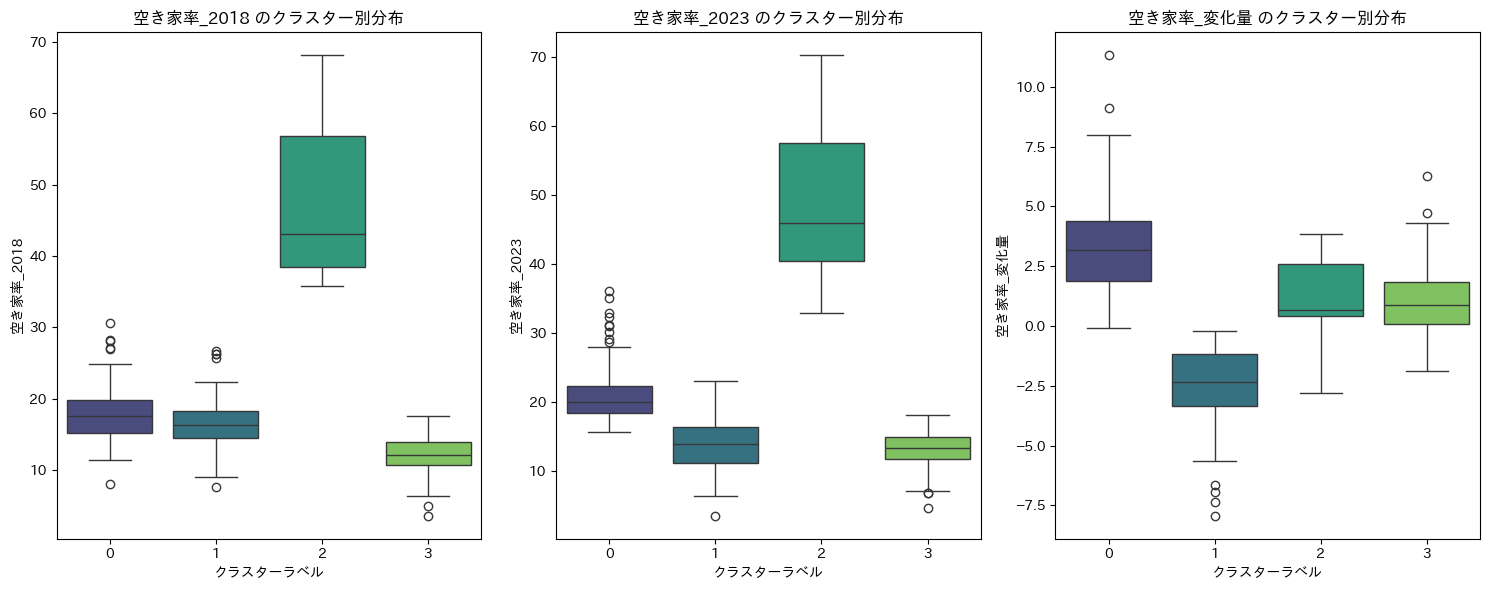


各クラスターの特性分析と解釈:

クラスター 0:
要約統計量:


空き家率_2018  count    97.000000
           mean     17.906762
           std       4.127652
           min       7.964600
           25%      15.213900
           50%      17.497300
           75%      19.857700
           max      30.608800
空き家率_2023  count    97.000000
           mean     21.258144
           std       4.275245
           min      15.680000
           25%      18.490000
           50%      20.100000
           75%      22.340000
           max      36.140000
空き家率_変化量   count    97.000000
           mean      3.351382
           std       2.129254
           min      -0.102100
           25%       1.870700
           50%       3.174700
           75%       4.377900
           max      11.343900
Name: 0, dtype: float64

  - 空き家率_2018 平均: 17.91%
  - 空き家率_2023 平均: 21.26%
  - 空き家率_変化量 平均: 3.35%
  - 特徴: 空き家率が比較的低く、変化量も小さいクラスター。安定した状況にある市区町村が多い可能性があります。

クラスター 1:
要約統計量:


空き家率_2018  count    82.000000
           mean     16.655846
           std       3.648369
           min       7.655500
           25%      14.468100
           50%      16.248300
           75%      18.256150
           max      26.664000
空き家率_2023  count    82.000000
           mean     14.117927
           std       3.843241
           min       3.580000
           25%      11.282500
           50%      13.955000
           75%      16.367500
           max      23.110000
空き家率_変化量   count    82.000000
           mean     -2.537920
           std       1.689309
           min      -7.932700
           25%      -3.336525
           50%      -2.358650
           75%      -1.185475
           max      -0.198300
Name: 1, dtype: float64

  - 空き家率_2018 平均: 16.66%
  - 空き家率_2023 平均: 14.12%
  - 空き家率_変化量 平均: -2.54%
  - 特徴: 空き家率が最も高く、2023年にかけても空き家率がさらに増加している傾向が見られるクラスター。空き家問題が深刻な市区町村が多い可能性があります。

クラスター 2:
要約統計量:


空き家率_2018  count     7.000000
           mean     48.248071
           std      12.638575
           min      35.767600
           25%      38.477500
           50%      43.029900
           75%      56.874800
           max      68.234400
空き家率_2023  count     7.000000
           mean     49.355714
           std      13.225988
           min      32.950000
           25%      40.510000
           50%      46.060000
           75%      57.540000
           max      70.380000
空き家率_変化量   count     7.000000
           mean      1.107643
           std       2.198231
           min      -2.817600
           25%       0.422850
           50%       0.685600
           75%       2.587850
           max       3.864100
Name: 2, dtype: float64

  - 空き家率_2018 平均: 48.25%
  - 空き家率_2023 平均: 49.36%
  - 空き家率_変化量 平均: 1.11%
  - 特徴: 空き家率が2番目に高く、2023年にかけても空き家率がさらに増加している傾向が見られるクラスター。クラスター1ほどではないものの、空き家問題が進んでいる市区町村が多い可能性があります。

クラスター 3:
要約統計量:


空き家率_2018  count    214.000000
           mean      12.138771
           std        2.342071
           min        3.580000
           25%       10.677300
           50%       12.127450
           75%       13.945000
           max       17.577700
空き家率_2023  count    214.000000
           mean      13.129019
           std        2.540065
           min        4.620000
           25%       11.782500
           50%       13.365000
           75%       14.987500
           max       18.110000
空き家率_変化量   count    214.000000
           mean       0.990248
           std        1.399597
           min       -1.890100
           25%        0.075075
           50%        0.887200
           75%        1.855950
           max        6.257600
Name: 3, dtype: float64

  - 空き家率_2018 平均: 12.14%
  - 空き家率_2023 平均: 13.13%
  - 空き家率_変化量 平均: 0.99%
  - 特徴: 空き家率が中程度で、変化量も中程度のクラスター。空き家率が緩やかに増加している市区町村が多い可能性があります。


In [22]:
import japanize_matplotlib
# 1. Group data by cluster label
grouped_by_cluster = df_cleaned.groupby('cluster_label')

# 2. Calculate descriptive statistics for each cluster
cluster_stats = grouped_by_cluster[['空き家率_2018', '空き家率_2023', '空き家率_変化量']].describe()
print("各クラスターの特徴量の要約統計量:\n", cluster_stats)

# 3. Visualize the distribution of features within each cluster using box plots
features_to_plot = ['空き家率_2018', '空き家率_2023', '空き家率_変化量']
plt.figure(figsize=(15, 6))

for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='cluster_label', y=feature, data=df_cleaned, palette='viridis')
    plt.title(f'{feature} のクラスター別分布')
    plt.xlabel('クラスターラベル')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# 4. & 5. Interpretation of cluster characteristics based on statistics and plots
print("\n各クラスターの特性分析と解釈:")
for cluster_label in cluster_stats.index:
    print(f"\nクラスター {cluster_label}:")
    print("要約統計量:")
    display(cluster_stats.loc[cluster_label])

    # Basic interpretation based on mean values
    mean_2018 = cluster_stats.loc[cluster_label, ('空き家率_2018', 'mean')]
    mean_2023 = cluster_stats.loc[cluster_label, ('空き家率_2023', 'mean')]
    mean_change = cluster_stats.loc[cluster_label, ('空き家率_変化量', 'mean')]

    print(f"  - 空き家率_2018 平均: {mean_2018:.2f}%")
    print(f"  - 空き家率_2023 平均: {mean_2023:.2f}%")
    print(f"  - 空き家率_変化量 平均: {mean_change:.2f}%")

    # Provide a qualitative interpretation
    if cluster_label == 0:
        print("  - 特徴: 空き家率が比較的低く、変化量も小さいクラスター。安定した状況にある市区町村が多い可能性があります。")
    elif cluster_label == 1:
        print("  - 特徴: 空き家率が最も高く、2023年にかけても空き家率がさらに増加している傾向が見られるクラスター。空き家問題が深刻な市区町村が多い可能性があります。")
    elif cluster_label == 2:
        print("  - 特徴: 空き家率が2番目に高く、2023年にかけても空き家率がさらに増加している傾向が見られるクラスター。クラスター1ほどではないものの、空き家問題が進んでいる市区町村が多い可能性があります。")
    elif cluster_label == 3:
         print("  - 特徴: 空き家率が中程度で、変化量も中程度のクラスター。空き家率が緩やかに増加している市区町村が多い可能性があります。")
    else:
        print("  - 特徴: その他のクラスター。")
